In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from haberrspd.preprocess import preprocessMJFF
                         
import pandas as pd
import re
import numpy as np
print(np.__version__)
from collections import Counter, defaultdict
import itertools
from operator import itemgetter
from scipy.stats import (gamma, lognorm, gengamma)

from pathlib import Path
from IPython.display import display

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Depending on where I am, set the path
import socket
if socket.gethostname() == 'pax':
    # Monster machine
    data_root = '../data/MJFF/' # My local path
    data_root = Path(data_root)
else:
    # Laptop
    data_root = '/home/nd/data/liverpool/MJFF' # My local path
    data_root = Path(data_root)

1.16.4


----

# Character + Timing data

In [2]:
proc = preprocessMJFF()

	Michael J. Fox Foundation PD copy-typing data.



In [12]:
out = proc('all')

Total number of study subjects: 61
Number of sentences typed by PD patients: 766
Number of sentences typed by controls: 1228
Average sentence length: 3808.02
Minimum sentence length: 395
Maximum sentence length: 13514


In [14]:
out.to_csv("../data/MJFF/preproc/EnglishSpanishData-preprocessed.csv",index=False)

In [10]:
out = proc('spanish')

/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2731: RuntimeWarning: divide by zero encountered in power
  return np.where(c > 0, val1, val2)**(1.0/c)


Total number of study subjects: 20
Number of sentences typed by PD patients: 340
Number of sentences typed by controls: 488
Average sentence length: 3542.27
Minimum sentence length: 1056
Maximum sentence length: 8759


In [11]:
out.to_csv("../data/MJFF/preproc/SpanishData-preprocessed.csv",index=False)

In [5]:
out = proc('english')

Total number of study subjects: 41
Number of sentences typed by PD patients: 426
Number of sentences typed by controls: 740
Average sentence length: 3996.73
Minimum sentence length: 395
Maximum sentence length: 13514


In [9]:
out.to_csv("../data/MJFF/preproc/EnglishData-preprocessed.csv",index=False)

In [8]:
pwd

'/home/neil/cloud/habitual_errors_NLP/notebooks'

In [8]:
out[out['Preprocessed_typed_sentence'].apply(lambda x: len(x) > 10000)]

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
506,28,1,60,AAAAAAAAAAAAAAAAAAAAAAAAssssssssssssssssssssss...
517,28,1,60,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
520,28,1,63,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
709,34,1,63,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
966,43,1,60,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
976,44,1,60,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
978,44,1,62,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGeeeeee...
979,44,1,55,hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...
984,44,1,60,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
985,44,1,61,LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL...


In [4]:
# df = pd.read_csv(data_root / 'SpanishData-duplicateeventsremoved.csv')
df = pd.read_csv(data_root / 'SpanishData.csv')
df_meta = pd.read_csv(data_root / "SpanishParticipantKey.csv",
                      index_col=0,
                      header=0,
                      names=['participant_id', 'diagnosis'])

# Character ONLY data

In [2]:
proc = preprocessMJFF()

	Michael J. Fox Foundation PD copy-typing data.



In [3]:
out = proc('english',include_time=False)

Total number of study subjects: 41
Number of sentences typed by PD patients: 426
Number of sentences typed by controls: 740
Average sentence length: 114.45
Minimum sentence length: 29
Maximum sentence length: 158


In [4]:
out.head()

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
0,10,0,55,"However, relagions other than islam, use a dif..."
1,10,0,56,"He is buried in Egypt, Aswamn at the Mayusoleu..."
2,10,0,57,"Books include penguin Island, a satire on the ..."
3,10,0,58,The w-shaoed glyph avbove the seoond consonnan...
4,10,0,59,The Franks alliance was important exactly beca...


In [13]:
out[out['Preprocessed_typed_sentence'].apply(lambda x: len(x) < 30)]

,Patient_ID,Diagnosis,Sentence_ID,Preprocessed_typed_sentence
685,33,0,68,However there is nno evidenc


In [13]:
out.to_csv("../data/MJFF/preproc/char/EnglishSpanishData-preprocessed.csv",index=False)

## PLOT


In [15]:
controls = set(df_meta.loc[df_meta.diagnosis == 0].participant_id)
pd_subjects = set(df_meta.loc[df_meta.diagnosis == 1].participant_id)

In [16]:
pd_timestamp_diffs = []
# Loop over all subjects
for sub in pd_subjects:
    # Get all delta timestamps for this sentence, across all subjects
    pd_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)
    
control_timestamp_diffs = []
# Loop over all subjects
for sub in controls:
    # Get all delta timestamps for this sentence, across all subjects
    control_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)

In [17]:
# remove NaNs
pd_cleaned_list = [x for x in pd_timestamp_diffs if str(x) != 'nan']
control_cleaned_list = [x for x in control_timestamp_diffs if str(x) != 'nan']

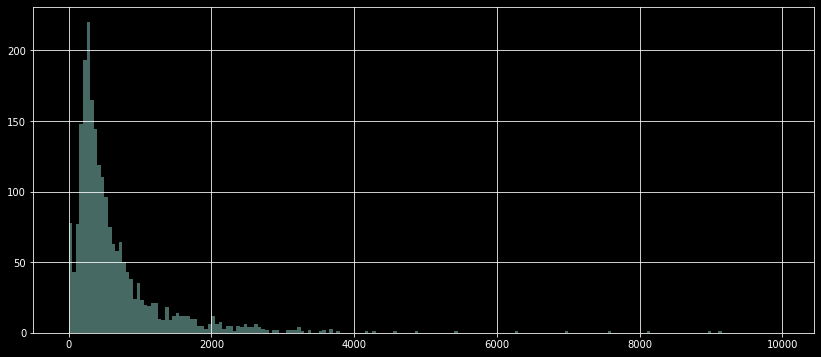

In [19]:
# PD

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(pd_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

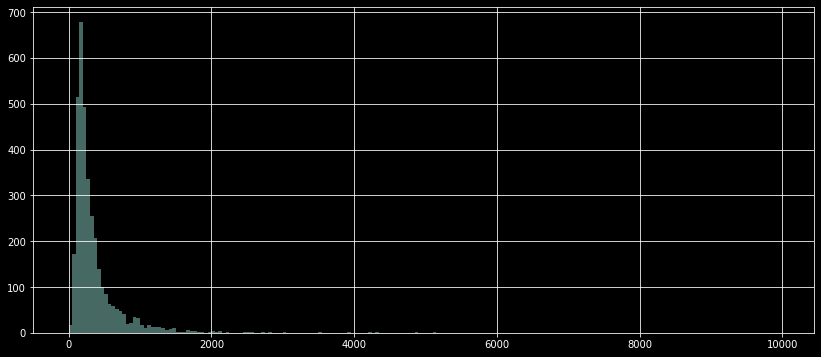

In [20]:
# control

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(control_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

### Mechanical turk data

In [15]:
out.to_csv(data_root /'preprocessed_MechanicalTurkCombinedEnglishData.csv',index=False)

In [14]:
ls ../data/MJFF/

EnglishData.csv
EnglishParticipantKey.csv
fasttext/
MechanicalTurkCombinedEnglishData.csv
MechanicalTurkEnglishParticipantKey.csv
MTurk1.csv
MTurk2.csv
preprocessed_EnglishData.csv
preprocessed_MechanicalTurkCombinedEnglishData.csv
README
SpanishData.csv
SpanishParticipantKey.csv
test_MJFF_English.csv
train_MJFF_English.csv
validate_MJFF_English.csv


### IKI extraction

In [4]:
out = create_mjff_iki_training_data(df)

## Keyboard inputs

In [2]:
from haberrspd.charCNN.data_utils_tf import create_mjff_data_objects, us_standard_layout_keyboard, english_keys_to_2d_coordinates
import keras.backend as K
from keras import callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from numpy import array, int64, ones, hstack, pad, einsum, dstack
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow import cast, float32, one_hot
import itertools

Using TensorFlow backend.


In [3]:
which_information = "char_time_space"
DATA_ROOT = Path("../data/") / "MJFF" / "preproc"
data_string = "EnglishData-preprocessed.csv"
if which_information == "char_time_space":
    # Get relevant long-format data
    which_information = "char_time"

In [4]:
df = read_csv(DATA_ROOT / which_information / data_string, header=0)  # MJFF data
subject_documents, subjects_diagnoses, alphabet = create_mjff_data_objects(df)

# Store alphabet size
alphabet_size = len(alphabet)

print('Total number of characters:', alphabet_size)
alphabet_indices = dict((c, i) for i, c in enumerate(alphabet))

if which_information == "char_time" or which_information == "char_time_space":
    # Rounds (up) to nearest thousand
    max_sentence_length = round(df.Preprocessed_typed_sentence.apply(lambda x: len(x)).max(), -3)
if which_information == "char":
    # Rounds (up) to nearest hundred
    max_sentence_length = round(df.Preprocessed_typed_sentence.apply(lambda x: len(x)).max(), -2)

# Make training data array
all_sentences = [item for sublist in subject_documents for item in sublist]

Total number of characters: 49


In [5]:
# Initialise tokenizer which maps characters to integers
tk = Tokenizer(num_words=None, char_level=True)

# Fit to text: convert all chars to ints
tk.fit_on_texts(all_sentences)

# Update alphabet
tk.word_index = alphabet_indices

# Get integer sequences: converts sequences of chars to sequences of ints
int_sequences = tk.texts_to_sequences(all_sentences)

# Pad sequences so that they all have the same length and then one-hot encode
X = to_categorical(pad_sequences(int_sequences, maxlen=max_sentence_length, padding='post'))

In [6]:
X.shape

(1166, 14000, 49)

In [7]:
which_information  =  'char_time_space'
if which_information == 'char_time_space':
    # Load relevant keyboard
    keyboard = us_standard_layout_keyboard()  # OBS: nested list
    # Check that all chars are in fact in our "keyboard" -- if not, we cannot map a coordinate
    assert alphabet.issubset(set(list(itertools.chain.from_iterable(keyboard))))
    space = [english_keys_to_2d_coordinates(sentence, keyboard) for sentence in all_sentences]
    space_padded = [pad(s, [(0, max_sentence_length - len(s)), (0, 0)], mode='constant') for s in space]
    # Append coordinates to one-hot encoded sentences
    X = einsum('ijk->kij', dstack([hstack((x, s)) for (x, s) in zip(X, space_padded)]))

In [8]:
X.shape

(1166, 14000, 51)